## Imports

In [163]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

import mysql.connector

import pandas as pd
import numpy as np

import time

## Data laoding
### Stockdata
* Load data from database
* Convert timestamp to date

In [164]:
user = 'mariadb'
password = 'mariadb'
database_name = 'mariadb'
host = 'db'
port = 3308

cnx = mysql.connector.connect(user='mariadb', password='mariadb',
                              host="localhost",
                              database=database_name,
                              port='3308')

stock_list_querry = "SELECT id, name FROM companies"
stock_list = pd.read_sql(stock_list_querry,cnx)
stock_data = {}
for index, row in stock_list.iterrows():
    symbol = row['name']
    id = int(row['id'])
    querry = "SELECT date, adj_close FROM stocks WHERE type_id = {};".format(id)
    stock_data[symbol] = pd.read_sql(querry,cnx)

print(stock_data[list(stock_data.keys())[0]].head)

/tmp/ipykernel_43254/2051174553.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stock_list = pd.read_sql(stock_list_querry,cnx)
/tmp/ipykernel_43254/2051174553.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stock_data[symbol] = pd.read_sql(querry,cnx)


<bound method NDFrame.head of            date  adj_close
0    1710201600      0.330
1    1710288000      0.330
2    1710374400      0.330
3    1710460800      0.330
4    1710720000      0.330
..          ...        ...
552  1709596800      0.360
553  1709683200      0.320
554  1709769600      0.290
555  1709856000      0.300
556  1710115200      0.325

[557 rows x 2 columns]>


<Axes: xlabel='adj_close', ylabel='date'>

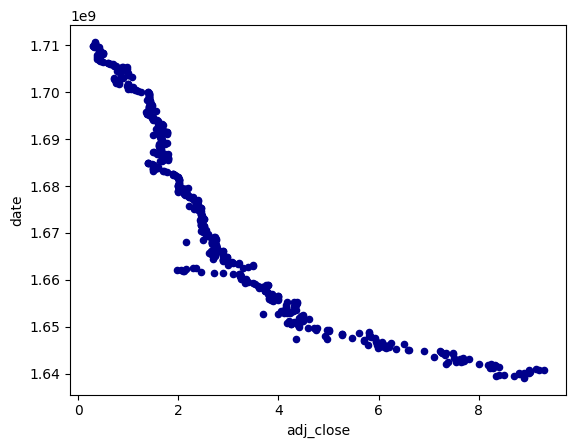

In [165]:
# visualize one stock
stock_data[list(stock_data.keys())[0]].plot.scatter(x='adj_close',y='date',c='DarkBlue')

### Short-selling-reports

In [166]:
short_list = pd.read_excel('stocks_with_listings.xlsx')

## Label Rows
* read time shifted `adj_close` into `signal` such that it can be compared to current date in one row without reverse lookupQQ
* compare previous day and set 1 if stock has risen

In [167]:
# label function
def label_row(row):
    if (row['signal'] - row['adj_close']) > 0:
        return 1
    else:
        return 0
def label_df(df):
    df['signal'] = df['adj_close'].shift(1)
    df.fillna(0)
    df['signal'] = df.apply(label,axis=1)
    return df

In [168]:
for i in stock_data:
    stock_data[i] = label_df(stock_data[i])

## Create Bands

In [169]:
for i in stock_data:
    df = stock_data[i]
    if(df['signal'].shape[0] < 10):
        print(i)
        print(df['signal'].shape)

ASIA
(8,)


## Create Testsplit

In [170]:
max_abs_scaler = preprocessing.MaxAbsScaler()
a = []
model_dict = {}
for i in stock_data:
    df = stock_data[i]
    # read df into np.array
    X = np.array(df.drop(['signal'],axis=1))
    X = max_abs_scaler.fit_transform(X)
    Y = np.array(df['signal'])

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


    model_dict[i] = {}
    model_dict[i]['X Train'] = X_train
    model_dict[i]['X Test'] = X_test
    model_dict[i]['Y Train'] = y_train
    model_dict[i]['Y Test'] = y_test
    
    model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    # model = svm.SVC(kernel='linear')
    # model = svm.SVC(kernel='linear',decision_function_shape='ovo')
    # model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    # model = svm.SVC(kernel='poly')
    # model = svm.SVC(kernel='poly',decision_function_shape='ovo')
    # model = svm.SVC(kernel='sigmoid')
    # model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')

    # fit and test
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_dict[i]['Y Prediction'] = y_pred
        #print("SVM Model Info for Ticker: "+i)
        #print("Accuracy:",metrics.accuracy_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction']))
        model_dict[i]['Accuracy'] = metrics.accuracy_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'])
        #print("Precision:",metrics.precision_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
        model_dict[i]['Precision'] = metrics.precision_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
        #print("Recall:",metrics.recall_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
        model_dict[i]['Recall'] = metrics.recall_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
        #print("#################### \n")
    except: 
        a.append(i)

/home/noi/Documents/BA/quant_trading/notebook/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/home/noi/Documents/BA/quant_trading/notebook/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/noi/Documents/BA/quant_trading/notebook/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1549: UserWarning: Note that pos_label (set to '1') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/home/noi/Documents/BA/quant_trading/no

In [190]:
for i in stock_data:
    #todo is this rly smart
    stock_data[i]['Returns'] = np.log(stock_data[i]['adj_close']/stock_data[i]['adj_close'].shift(1)) 

    prediction_length = len(model_dict[i]['Y Prediction'])

    stock_data[i]['SVM Signal'] = 0
    stock_data[i]['SVM Returns'] = 0
    stock_data[i]['Total Strat Returns'] = 0
    stock_data[i]['Market Returns'] = 0

    Signal_Column = stock_data[i].columns.get_loc('SVM Signal')
    Strat_Column = stock_data[i].columns.get_loc('SVM Returns')
    Return_Column = stock_data[i].columns.get_loc('Total Strat Returns')
    Market_Column = stock_data[i].columns.get_loc('Market Returns')
        
    stock_data[i].iloc[-prediction_length:,Signal_Column] = list(map(int,model_dict[i]['Y Prediction']))
    stock_data[i]['SVM Returns'] = stock_data[i]['SVM Signal'] * stock_data[i]['Returns'].shift(1)

    stock_data[i].iloc[-prediction_length:,Return_Column] = np.nancumsum(stock_data[i]['SVM Returns'][-prediction_length:])
    stock_data[i].iloc[-prediction_length:,Market_Column] = np.nancumsum(stock_data[i]['Returns'][-prediction_length:])
    print(stock_data[i]['Total Strat Returns'].head)

    # model_dict[i]['Sharpe_Ratio'] = (stock_data[i]['Total Strat Returns'][-1] - stock_data[i]['Market Returns'][-1])/ \
    #                 np.nanstd(stock_data[i]['Total Strat Returns'][-prediction_length:])

/tmp/ipykernel_43254/271433288.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.14589665e-02
  7.14589665e-02  9.41871960e-02  3.63676100e-02  3.63676100e-02
  3.03974485e-02  1.83491213e-02  1.83491213e-02  1.83491213e-02
  1.83491213e-02  1.83491213e-02  1.83491213e-02  1.22700809e-02
  1.22700809e-02  1.22700809e-02 -8.36500258e-02 -1.24225080e-02
  8.85533836e-02  8.85533836e-02  8.85533836e-02  8.85533836e-02
  4.23024106e-02  4.23024106e-02  4.23024106e-02  1.83491213e-02
 -4.41712520e-02  1.83491213e-02  1.22700809e-02  6.15385971e-03
 -6.19196431e-03 -1.24225080e-02 -6.19196431e-03  4.23024106e-02
  3.63676100e-02 -1.66533454e-16 -1.24225080e-02 -1.24225080e-02
 -1.24225080e-02 -2.50012780e-02 -2.50012780e-02 -7.69610441e-02
 -7.69610441e-02 -9.71637319e-02 -8.36500258e-02 -8.36500258e-02
 -9.71637319e-02 -1.03989690e-01 -1.24751745e-01 -1.3

<bound method NDFrame.head of 0      0
1      0
2      0
3      0
4      0
      ..
552    0
553    0
554    0
555    0
556    0
Name: Total Strat Returns, Length: 557, dtype: int64>
<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
2464    0
2465    0
2466    0
2467    0
2468    0
Name: Total Strat Returns, Length: 2469, dtype: int64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2461   -0.335074
2462   -0.335074
2463   -0.327185
2464   -0.327185
2465   -0.326482
Name: Total Strat Returns, Length: 2466, dtype: float64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2461   -0.373717
2462   -0.373717
2463   -0.373717
2464   -0.388124
2465   -0.384369
Name: Total Strat Returns, Length: 2466, dtype: float64>
<bound method NDFrame.head of 0      0.000000
1      0.000000
2      0.000

/tmp/ipykernel_43254/271433288.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.         -0.          0.          0.          0.          0.
 -0.05004093 -0.05004093 -0.05004093 -0.05004093 -0.097627   -0.097627
 -0.097627   -0.097627   -0.097627   -0.097627   -0.097627   -0.097627
 -0.05293433 -0.05293433 -0.05293433 -0.05293433 -0.05293433 -0.05293433
 -0.05293433 -0.05293433 -0.05293433 -0.05293433 -0.05293433 -0.05293433
 -0.05293433 -0.05293433 -0.05293433 -0.05293433 -0.15661279 -0.15661279
 -0.15661279 -0.15661279  0.06026119  0.06026119  0.06026119  0.06026119
  0.01457621  0.01457621  0.02657288  0.02657288  0.02657288  0.02657288
  0.02657288  0.02657288  0.02657288  0.02657288  0.02657288  0.08588163
  0.08588163  0.2668343   0.13655916  0.13655916  0.07742861  0.07742861
  0.07742861  0.07742861  0.16111641  0.16111641  0.16111641  0.16111641
  0.16111641  0.16111641  0.16111641  0.16

<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2518   -1.017768
2519   -1.101256
2520   -1.095992
2521   -1.047327
2522   -1.015344
Name: Total Strat Returns, Length: 2523, dtype: float64>
<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
2518    0
2519    0
2520    0
2521    0
2522    0
Name: Total Strat Returns, Length: 2523, dtype: int64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1734    0.425958
1735    0.440774
1736    0.420388
1737    0.448724
1738    0.448724
Name: Total Strat Returns, Length: 1739, dtype: float64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1506    0.189251
1507    0.229289
1508    0.229289
1509    0.229289
1510    0.229289
Name: Total Strat Returns, Length: 1511,

/tmp/ipykernel_43254/271433288.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.         -0.          0.          0.          0.          0.
  0.          0.          0.         -0.03166488 -0.03166488 -0.03166488
 -0.03166488 -0.03166488 -0.03166488 -0.03166488 -0.03166488 -0.03166488
 -0.03166488 -0.03166488  0.07494487  0.07494487  0.07494487 -0.01318552
 -0.01318552 -0.01318552 -0.01318552 -0.01318552 -0.06572047 -0.06572047
 -0.06572047 -0.06572047 -0.07240945 -0.07240945 -0.07240945 -0.12067618
 -0.12067618 -0.12067618 -0.08319313 -0.08319313 -0.08319313 -0.08319313
 -0.28465396 -0.28465396 -0.28465396 -0.28465396 -0.28465396 -0.28465396
 -0.28465396 -0.28465396 -0.28465396 -0.28465396 -0.28465396 -0.28465396
 -0.28465396 -0.28465396 -0.28465396 -0.28465396 -0.28465396 -0.28465396
 -0.28465396 -0.28465396 -0.28465396 -0.28465396 -0.28465396 -0.28465396
 -0.28465396 -0.28465396 -0.28465396 -

<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2518   -2.179479
2519   -2.179479
2520   -2.179479
2521   -2.179479
2522   -2.313011
Name: Total Strat Returns, Length: 2523, dtype: float64>
<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
2376    0
2377    0
2378    0
2379    0
2380    0
Name: Total Strat Returns, Length: 2381, dtype: int64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1512   -0.744903
1513   -0.744903
1514   -0.699411
1515   -0.718655
1516   -0.691816
Name: Total Strat Returns, Length: 1517, dtype: float64>
<bound method NDFrame.head of 0      0
1      0
2      0
3      0
4      0
      ..
814    0
815    0
816    0
817    0
818    0
Name: Total Strat Returns, Length: 819, dtype: int64>
<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4   

/tmp/ipykernel_43254/271433288.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.          0.          0.          0.          0.02678729  0.02678729
  0.02678729  0.02678729  0.02678729 -0.03680375 -0.03680375 -0.03680375
 -0.02113765 -0.02113765 -0.02113765 -0.04838733 -0.04838733 -0.04838733
 -0.04838733 -0.04838733 -0.04838733 -0.04838733 -0.05392751 -0.05392751
 -0.08901886 -0.15673697 -0.14407859 -0.14407859 -0.14407859 -0.15308765
 -0.15308765 -0.31796235 -0.1814871  -0.24520295 -0.24520295 -0.24520295
 -0.24520295 -0.26582222 -0.24112963 -0.24112963 -0.23272613 -0.23272613
 -0.23272613 -0.28841508 -0.28841508 -0.28025178 -0.31752324 -0.31752324
 -0.31752324 -0.35607197 -0.35607197 -0.35607197 -0.40760569 -0.32904333
 -0.32904333 -0.32904333 -0.32904333 -0.32904333 -0.32904333 -0.32904333
 -0.40908607 -0.48545904 -0.48545904 -0.48545904 -0.48545904 -0.48034394
 -0.48545904 -0.48545904 -0.48

<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
2519    0
2520    0
2521    0
2522    0
2523    0
Name: Total Strat Returns, Length: 2524, dtype: int64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1332   -1.979181
1333   -2.109952
1334   -2.139805
1335   -2.194293
1336   -2.218586
Name: Total Strat Returns, Length: 1337, dtype: float64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1452   -1.250264
1453   -1.250264
1454   -1.250264
1455   -1.250264
1456   -1.250264
Name: Total Strat Returns, Length: 1457, dtype: float64>
<bound method NDFrame.head of 0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
893    0.294433
894    0.209254
895    0.258473
896    0.230994
897    0.229037
Name: Total Strat Returns, Length: 898, dtype: floa

/tmp/ipykernel_43254/271433288.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00000000e+00  1.38890988e-02  4.37826010e-02  3.97584865e-02
  1.80185210e-02  5.24464418e-02  5.24464418e-02  5.24464418e-02
  7.19149466e-02  7.95974353e-02  5.57176380e-02  7.83210817e-02
  5.96289510e-02  5.96289510e-02  7.59653628e-02  7.59653628e-02
  7.59653628e-02  7.73004434e-02  1.03635117e-01  1.03635117e-01
  1.03635117e-01  1.03635117e-01  1.03635117e-01  1.10675185e-01
  1.10675185e-01  1.10675185e-01  9.04328731e-02  7.84884505e-02
  8.44784954e-02 -7.02253040e-02 -7.02253040e-02 -7.58546433e-02
 -3.09120662e-02 -4.48874725e-02 -3.01414091e-02 -8.80251481e-02
 -8.15157741e-02 -5.78703553e-03 -5.78703553e-03 -2.00629824e-03
 -2.72273464e-02 -9.58212106e-03 -3.65586648e-02  2.51181326e-03
 -4.97967833e-04 -4.97967833e-04  2.22053445e-02  2.22053445e-02
  2.22053445e-02  3.51350638e-02 -5.57425914e-03 -5.5

<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2496   -1.700546
2497   -1.575092
2498   -1.562076
2499   -1.570734
2500   -1.570734
Name: Total Strat Returns, Length: 2501, dtype: float64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2434    0.048133
2435    0.048133
2436    0.048133
2437    0.048133
2438    0.048133
Name: Total Strat Returns, Length: 2439, dtype: float64>
<bound method NDFrame.head of 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2519   -0.000592
2520   -0.000592
2521   -0.000592
2522   -0.000592
2523   -0.000592
Name: Total Strat Returns, Length: 2524, dtype: float64>
<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
2537    0
2538    0
2539    0
2540    0
2541    0
Name: Total Strat Returns, Length: 254

/tmp/ipykernel_43254/271433288.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00567062 -0.02603855 -0.03309833 -0.02586282 -0.0285038  -0.02920935
 -0.05548654 -0.03504847 -0.01467196 -0.01293456  0.00734113 -0.0320362
 -0.02568697 -0.01206714 -0.04020815 -0.05494338 -0.06093532 -0.06403589
 -0.07321205 -0.09050673 -0.08788415 -0.08061418 -0.07875854 -0.08359021
 -0.10106713 -0.0980384  -0.10087748 -0.09860548 -0.12699246 -0.11904756
 -0.12446671 -0.11866156 -0.11827595 -0.0848951  -0.10638914 -0.10315449
 -0.07247491 -0.07786269 -0.06988413 -0.09382388 -0.11776917 -0.07804915
 -0.07266015 -0.06822231 -0.06527466 -0.09856732 -0.10295131 -0.10582079
 -0.11563897 -0.14508748 -0.14250057 -0.15268744 -0.13143319 -0.1308438
 -0.13932599 -0.11835106 -0.09989972 -0.05794331 -0.06988413 -0.08103476
 -0.07842181 -0.07860815 -0.07340182 -0.09155515 -0.10218748 -0.10333336
 -0.12418766 -0.08178237 -0.0689

,date,adj_close,signal
0,2024-03-12,203.205933,None
1,2024-03-13,202.179993,None
2,2024-03-14,199.729996,None
3,2024-03-15,200.199997,None
4,2024-03-18,201.199997,None


In [181]:
print(a)
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},

          {'a': 100, 'b': 200, 'c': 300, 'd': 400},

          {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000}]

df = pd.DataFrame(mydict)

print(df)
print(df.iloc[1:,1])


[]
      a     b     c     d
0     1     2     3     4
1   100   200   300   400
2  1000  2000  3000  4000
1     200
2    2000
Name: b, dtype: int64
